In [ ]:
#!pip install tensorflow keras split-folders opencv-python
#!pip install split-folders

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import splitfolders
import cv2
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers, models
import os
import random
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
# Executar essa cédula pra conectar o Colab ao Drive
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
input_folder = "bloodcells_dataset"
output_folder = "image_recognition"

In [ ]:
split_ratio = (0.8, 0.1, 0.1)
splitfolders.ratio(
    input_folder,
    output=output_folder,
    seed=42,
    ratio=split_ratio,
    group_prefix=None
)   # Cria as pastas test, train e val no image_recognition


Copying files: 17102 files [1:10:06,  4.07 files/s]


In [ ]:
# Define the parameters
img_size = (360, 360)
batch_size = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,    # resnet50
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
# Data augmentation for test data (only rescaling)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
# Data augmentation for validation data (only rescaling)
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
train_dir = os.path.join(output_folder, 'train')
test_dir = os.path.join(output_folder, 'test')
valid_dir = os.path.join(output_folder, 'val')

In [ ]:
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False # Evita inconsistência na predição
)

valid_data = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 13679 images belonging to 8 classes.
Found 1717 images belonging to 8 classes.
Found 1706 images belonging to 8 classes.


In [ ]:
# Get a batch of images and labels
images, labels = next(valid_data)

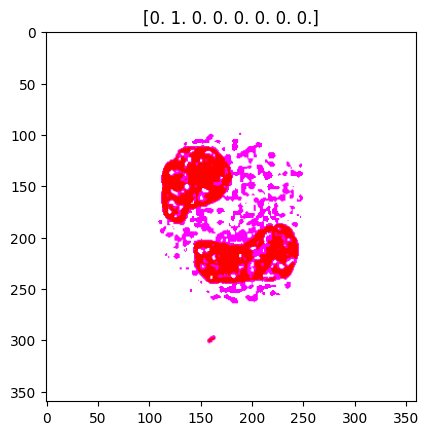

In [ ]:
# Select a random image from the batch
idx =  random.randint(0, images.shape[0] - 1)

# Display the image
plt.imshow(images[idx])
plt.title(labels[idx])
plt.show()

In [ ]:
from keras.applications.resnet50 import ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))

# Freeze the convolutional base
base_model.trainable = False

In [ ]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(8, activation='softmax')
])

In [ ]:
# Rodar apenas se tiver o treinamento já carregado
model.load_weights('/content/drive/MyDrive/IA/bloodcells_image_recognition/CropModel.keras')

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Rodar apenas ao treinar o algoritmo
# model.fit(train_data, epochs=10, validation_data=valid_data)

In [ ]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_data)

print(f'Test accuracy: {test_accuracy * 100:.2f}%')

In [ ]:
class_names = {0: 'basophil', 1: 'eosinophil', 2: 'erythroblast', 3:'ig', 4:'lymphocyte',
               5:'monocyte', 6:'neutrophil', 7:'platelet'}

In [ ]:
def predict_img(image,model):
    test_img=cv2.imread(image)
    test_img=cv2.resize(test_img, img_size)
    test_img=np.expand_dims(test_img, axis=0)
    result=model.predict(test_img)
    r=np.argmax(result)
    print(class_names[r])

In [ ]:
predict_img('/content/drive/MyDrive/IA/bloodcells_image_recognition/bloodcells_dataset/erythroblast/ERB_115914.jpg', model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
erythroblast


54/54 ━━━━━━━━━━━━━━━━━━━━ 687s 13s/step


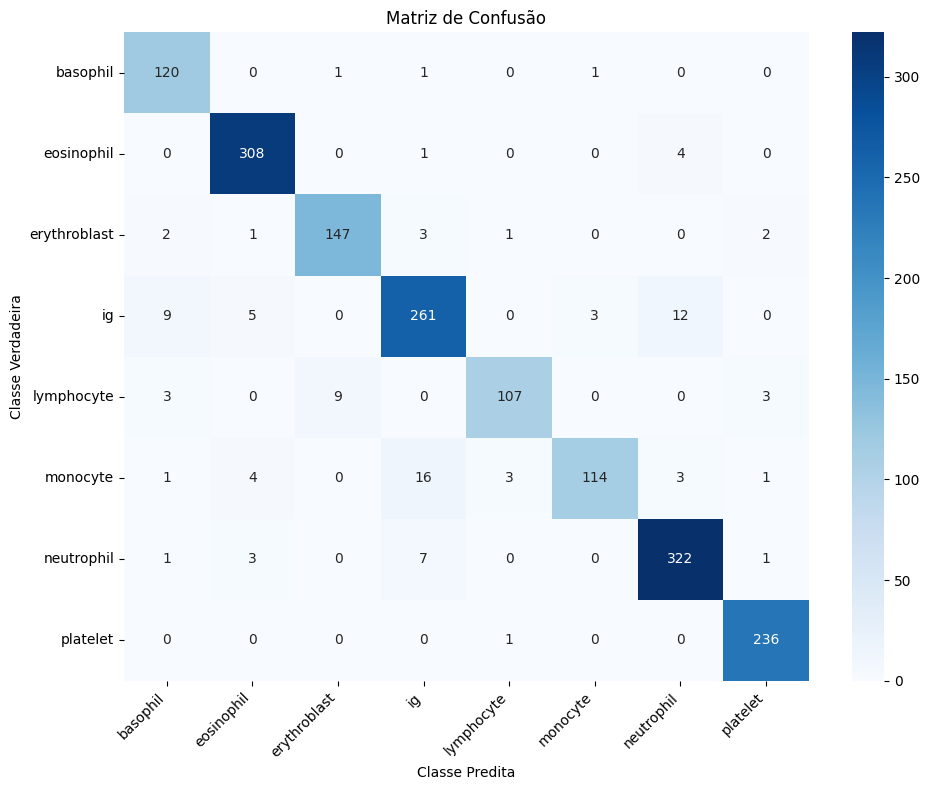


Relatório de Classificação:
              precision    recall  f1-score   support

    basophil       0.88      0.98      0.93       123
  eosinophil       0.96      0.98      0.97       313
erythroblast       0.94      0.94      0.94       156
          ig       0.90      0.90      0.90       290
  lymphocyte       0.96      0.88      0.91       122
    monocyte       0.97      0.80      0.88       142
  neutrophil       0.94      0.96      0.95       334
    platelet       0.97      1.00      0.98       237

    accuracy                           0.94      1717
   macro avg       0.94      0.93      0.93      1717
weighted avg       0.94      0.94      0.94      1717



In [ ]:
# Certifique-se de que o modelo está carregado ou treinado antes de executar esta célula.
# Se você não treinou o modelo na sessão atual e está apenas carregando os pesos,
# verifique se a célula model.load_weights() foi executada sem erros.

# 1. Fazer previsões no conjunto de teste
# O número de passos deve cobrir todo o conjunto de teste
num_test_samples = test_data.samples
# Se test_data.batch_size foi alterado para predição, use esse valor, senão use o batch_size original
# Para garantir, podemos recalcular batch_size aqui se necessário ou usar o global

# Y_pred_probs conterá as probabilidades para cada classe
Y_pred_probs = model.predict(test_data, steps=int(np.ceil(num_test_samples / test_data.batch_size)))

# Y_pred conterá a classe predita (o índice da classe com maior probabilidade)
Y_pred = np.argmax(Y_pred_probs, axis=1)

# 2. Obter os rótulos verdadeiros
# Como definimos shuffle=False para test_data, test_data.classes nos dará os rótulos na ordem correta
Y_true = test_data.classes

# 3. Obter os nomes das classes para o plot
# Precisamos deles como uma lista na ordem dos índices para o heatmap
target_names = [class_names[i] for i in range(len(class_names))]

# 4. Calcular a matriz de confusão
cm = confusion_matrix(Y_true, Y_pred)

# 5. Visualizar a matriz de confusão
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.title('Matriz de Confusão')
plt.ylabel('Classe Verdadeira')
plt.xlabel('Classe Predita')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout() # Ajusta o layout para evitar que os rótulos se sobreponham
plt.show()

# 6. (Opcional) Exibir o relatório de classificação para mais métricas (precisão, recall, f1-score)
print("\nRelatório de Classificação:")
print(classification_report(Y_true, Y_pred, target_names=target_names))